In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%load_ext autoreload
%autoreload 2

from gradio_utils import motionctrl_cmcm_gradio
import torch
from gradio_utils import camera_utils
import numpy as np
import viz
import visu3d as v3d
from tqdm import tqdm
import mediapy
# !nvidia-smi

In [2]:
num_frames = 14
num_steps = 25
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

config = "configs/inference/config_motionctrl_cmcm.yaml"
ckpt='motionctrl_svd.ckpt'

model = motionctrl_cmcm_gradio.build_model(
    config,
    ckpt,
    device,
    num_frames,
    num_steps)

Using device cuda
Loading model from motionctrl_svd.ckpt
Initialized embedder #0: FrozenOpenCLIPImagePredictionEmbedder with 683800065 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: VideoPredictionEmbedderWithEncoder with 83653863 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
Restored from motionctrl_svd.ckpt with 0 missing and 0 unexpected keys


In [3]:
type(model)

sgm.motionctrl.camera_motion_control.CameraMotionControl

In [4]:
def get_cam_angle(angle):
    R = camera_utils.compute_R_form_rad_angle(
        np.array(angle))
    T = np.array([0, 0, 0])
    cam = np.concatenate([R, T[:,None]], axis=1)
    
    return cam

cam_acw = get_cam_angle([0, 0, 1])
cam_cw = get_cam_angle([0, 0, -1])
cam_id = get_cam_angle([0, 0, 0])
cam_eye = np.eye(4)

viz_cam_acw = viz.get_camera_matrices_as_rays((None, cam_acw[None]))
viz_cam_cw = viz.get_camera_matrices_as_rays((None, cam_cw[None]))
viz_cam_id = viz.get_camera_matrices_as_rays((None, cam_id[None]))
viz_cam_eye = viz.get_camera_matrices_as_rays((None, cam_eye[None]))


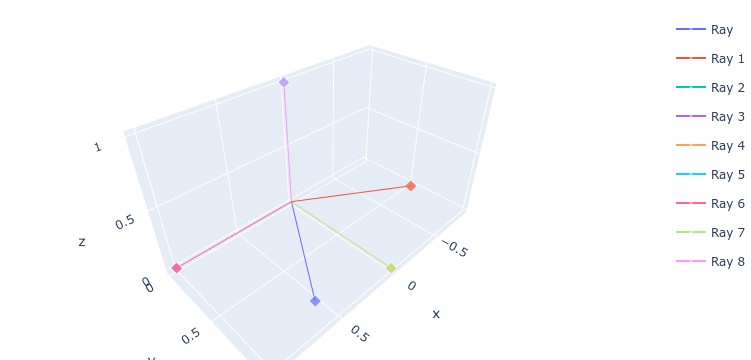

In [5]:
v3d.make_fig(
    *viz_cam_acw,
    # *viz_cam_cw,
    *viz_cam_id,
    *viz_cam_eye,
)

In [24]:
import sys

def load_various_sgm(h, w, droid_downsample, dataset):
    del sys.modules['sgm']
    sys.path.insert(0, '/home/jupyter/generative-models/')
    import sgm
    
    import mediapy
    from sgm.data.massive import webdataset_utils
    from sgm.data.massive import webdataset_co3d
    from tqdm import tqdm
    from omegaconf import OmegaConf
    from sgm.util import exists, instantiate_from_config, isheatmap
    import torch

    config = OmegaConf.load('/home/jupyter/generative-models/configs/example_training/svd_train.yaml')
    config2 = OmegaConf.load('/home/jupyter/generative-models/configs/example_training/sketch.yaml')
    config = OmegaConf.merge(config, config2)

    config.data.params.train_config.batch_size = 1
    config.data.params.val_config.batch_size = 1

    # config.data.params.train_config.dataset_config_1.dataset_url = "gs://xcloud-shared/kylesargent/mit_unresized/mit_val__{shard:04d}.tar"
    # config.data.params.train_config.dataset_config_1.dataset_n_shards = 1
    # config.data.params.train_config.dataset_config_1.dataset_url = "gs://xcloud-shared/kylesargent/bucketed_test/sstk__00010.tar"
    # config.data.params.train_config.dataset_config_1.dataset_n_shards = 1
    # config.data.params.train_config.dataset_config_1.dataset_url = "gs://xcloud-shared/kylesargent/flow_bucketed_sstk_576p_16frames_3fps_v2/sstk__99999.tar"
    # config.data.params.train_config.dataset_config_1.dataset_n_shards = 1

    if dataset=='re10k':
        config.data.params.val_config.dataset_config_1.dataset_url="gs://xcloud-shared/kylesargent/re10k_test.tar"
    else:
        config.data.params.val_config.dataset_config_1.dataset_url="gs://xcloud-shared/kylesargent/co3d_highres_v2/co3d__00027.tar"
        
    config.data.params.train_config.shuffle_buffer_size = 0
    config.data.params.train_config.num_workers = 0
    # config.data.params.train_config.downsample_f = "(192, 128)"
    # config.data.params.val_config.downsample_f = "(192, 128)"
    config.data.params.train_config.num_frames=14
    config.data.params.val_config.num_frames=14

    config.data.params.train_config.balance=1_000
    # config.data.params.train_config.downsample_f = "(384, 256)"
    # config.data.params.val_config.downsample_f = "(384, 256)"
    config.data.params.train_config.downsample_f = f"({w}, {h})"
    config.data.params.val_config.downsample_f = f"({w}, {h})"
    config.data.params.train_config.prefetch_factor = 2
    dm = instantiate_from_config(config.data)
    
    from sgm.data import video_metrics
    def droid_slam_getter():
        droid_slam = video_metrics.load_droid_slam(w=w//droid_downsample,h=h//droid_downsample)
        return droid_slam
    
    sys.path = sys.path[1:]
    intrinsics = torch.as_tensor([h/2, h/2, w/2, h/2], device='cuda')

    import sgm
    
    return dm, droid_slam_getter, intrinsics, video_metrics

In [25]:
def run_motionctrl(model, batch):
    image = batch['cond_frames_without_noise'][0]
    image = image.permute((1,2,0))/2 + .5

    image = viz.fi(image)

    relative_pose = torch.linalg.inv(batch['aux_cond_cam2world']) @ batch['aux_target_cam2world']
    relative_pose = relative_pose[:, :3].cpu().numpy()

    with torch.no_grad():
        sample = motionctrl_cmcm_gradio.motionctrl_sample(model, image, relative_pose, num_frames=14)
    sample = sample*2 - 1
    # sample_np = sample.permute((0, 2, 3, 1)).cpu().numpy()
    # mediapy.show_video(sample_np, height=576//2, width=1024//2, codec='gif', fps=4)
    # return sample_np
    return sample

def reduce_metrics(dict_list):
    return {
        k:np.mean([d[k] for d in dict_list])
        for k in dict_list[0]
    }

In [26]:
import einops

def videocomposer_iterator(dataset_name):
    basedir = os.path.join("/home/jupyter/videocomposer/benchmarking/", dataset_name)
    assert os.path.exists(basedir)
    
    # if dataset_name == 're10k':
    # !ls {basedir}
    for idx in range(100):
        input_image_path = "%.5d_input.png" % idx
        gt_video_path = os.path.join(basedir, "%.5d_target.mp4" % idx)
        
        pred_video_path = os.path.join(basedir, "%.5d" % idx, "rank_2-0.mp4")
        pred_video = mediapy.read_video(pred_video_path)
        gt_video = mediapy.read_video(gt_video_path)
        
        pred_video = einops.rearrange(pred_video, "t h (four w) three -> four t h w three", four=4, three=3)[3]
        
        def to_tensor(video):
            return torch.as_tensor(video).to(torch.float32).cuda().permute((0, 3, 1, 2))*2-1
        yield to_tensor(gt_video/255.), to_tensor(pred_video/255.), 45.0

    
# gt_video, pred_video, fov = next(iter(videocomposer_iterator("re10k")))

In [ ]:
mediapy.show_video(
    pred_video.permute((0, 2,3 , 1)).cpu().numpy()/2 + .5)

In [ ]:
import lpips
clip_model = video_metrics.FrozenCLIPImageEmbedder()
lpips_model = lpips.LPIPS().eval()

re10k (256, 256) videocomposer
1



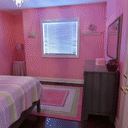


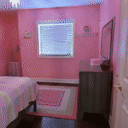

NameError: name 'lpips_model' is not defined

In [28]:
def show_video(video):
    jpg = video.permute((0, 2, 3, 1))/2+.5
    _,h,w,_ = jpg.shape
    jpg = jpg.cpu().numpy()
    mediapy.show_video(jpg, fps=4, codec='gif', height=h//2, width=w//2)

def motionctrl_iterator(dl):
    n = 100
    for batch, idx in tqdm(zip(dl, range(n)), total=n):
        # 
        pred_motionctrl = run_motionctrl(model, batch)
        yield batch['jpg'].cuda(), pred_motionctrl, batch['aux_fov_deg'].ravel()[0].item()
        

warpnvs_zoo = {
    f"co3d_(256, 384)": (110377914, 1),
    f"re10k_(256, 384)": (110377914, 3),
    f"co3d_(576, 1024)": (110377914, 2),
    f"re10k_(576, 1024)": (110377914, 4),
}
import glob

def get_warpnvs_video_iterator(xid, wid):
    pattern = f'/gcs/xcloud-shared/kylesargent/zero123_training_runs/{xid}/{wid}/logs/*/videos/val/*npy'
    
    for filepath in tqdm(sorted(glob.glob(pattern))[:100]):
        result_dict = np.load(filepath, allow_pickle=True).item()
        
        gt_video = torch.as_tensor(result_dict['gt_video']).cuda()
        pred_video = torch.as_tensor(result_dict['sampled_video']).cuda()
        fov_deg = result_dict['aux_gt_fov_deg']
        yield gt_video*2-1, pred_video*2-1, fov_deg
        

all_metrics = {}
for dataset in [
    're10k',
    'co3d',
]:
    for resolution in [
        # (256, 384),
        # (576, 1024),
        (256, 256),
    ]:
        for model_name in [
            # 'warpnvs',
            # 'motionctrl'
            "videocomposer",
        ]:
            print(dataset, resolution, model_name)
            
            h,w = resolution
            droid_downsample=2 if h > 256 else 1
            print(droid_downsample)
            
            dm, droid_slam_getter, intrinsics, video_metrics = load_various_sgm(
                h=h,w=w, droid_downsample=droid_downsample, dataset=dataset)
            if model_name == 'motionctrl':
                iterator = motionctrl_iterator(iter(dm.val_dataloader()))
            elif model_name == 'warpnvs':
                xid, wid = warpnvs_zoo[f"{dataset}_{resolution}"]
                iterator = get_warpnvs_video_iterator(xid, wid)
            elif model_name == 'videocomposer':
                assert resolution == (256, 256)
                iterator = videocomposer_iterator(dataset)
            else:
                raise NotImplementedError
                
            metrics_dicts = []
            for gt_video, pred_video, fov_deg in iterator:
                show_video(gt_video)
                show_video(pred_video)
                print()
                metrics_dict = video_metrics.get_video_metrics_stateless(
                    droid_slam_getter=droid_slam_getter,
                    droid_downsample=droid_downsample,
                    lpips_model=lpips_model,
                    clip_model=clip_model,
                    gt_video=gt_video/2+.5, 
                    pred_video=pred_video/2+.5,
                    # fovy_deg=batch['aux_fov_deg'].ravel()[0].item()
                    fovy_deg=fov_deg,
                )
                metrics_dicts.append(metrics_dict)
            all_metrics[f"{dataset}_{resolution}_{model_name}"] = metrics_dicts

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/jupyter/conda/pkgs/generative-models/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter/conda/pkgs/generative-models/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/jupyter/conda/pkgs/generative-models/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [106]:
result_dict.item().keys()

dict_keys(['sampled_video', 'gt_video', 'aux_gt_fov_deg', 'aux_force_fov_deg'])

In [49]:
metrics_dict

{'lpips': 0.59439194,
 'psnr': 14.246885802706634,
 'clip': 0.16717879048415593,
 'roterr': 0.21543657961251775,
 'transerr': 2.6764330863952637}

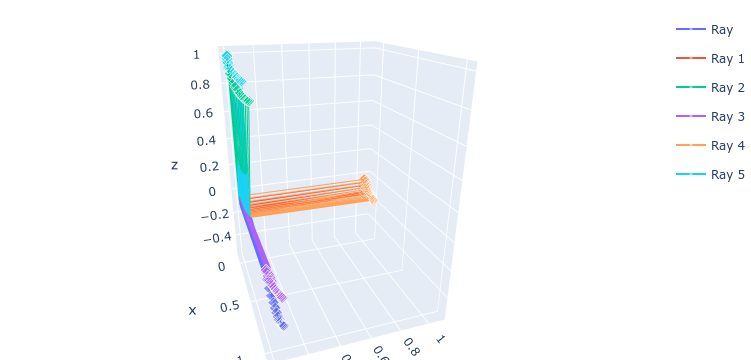

In [32]:
# translations = poses[:, :3]
# rotations = pytorch3d.transforms.quaternion_to_matrix(poses[:, 3:])

# inhomogeneous_extrinsics = torch.concatenate([
#     rotations, translations[..., None]], axis=2)

# extrinsics = steer.homogenize_poses(inhomogeneous_extrinsics)
# # extrinsics = torch.linalg.inv(extrinsics)
# extrinsics[:, 0] *= -1
# extrinsics[:, 1] *= -1
# extrinsics.shape

import pytorch3d
from sgm.data import steer

import viz
import visu3d as v3d



viz_cam_gt = viz.get_camera_matrices_as_rays((None, gt_poses.cpu().numpy()))
viz_cam_pred = viz.get_camera_matrices_as_rays((None, pred_poses.cpu().numpy()))

# viz_cam_2 = viz.get_camera_matrices_as_rays((None, np.eye(4)[None]))

v3d.make_fig(
    *viz_cam_gt,
    *viz_cam_pred,
    # *viz_cam_2
)

In [51]:
np.rad2deg(np.arctan2(cy, fy))*2, intrinsics

(61.005618822945586,
 tensor([244.4361, 244.4361, 256.0000, 144.0000], dtype=torch.float64))

In [35]:

video_metrics.compute_roterr(gt_poses, pred_poses)
video_metrics.compute_transerr(gt_poses, pred_poses)

tensor(2.7289, device='cuda:0')

In [23]:
gt_poses[:, :3, -1], pred_poses[:, :3, -1]

(tensor([[ 0.0000,  0.0000,  0.0000],
         [-0.0056, -0.0008, -0.0348],
         [-0.0120,  0.0020, -0.0702],
         [-0.0190,  0.0069, -0.1003],
         [-0.0266,  0.0136, -0.1257],
         [-0.0339,  0.0211, -0.1461],
         [-0.0408,  0.0278, -0.1624],
         [-0.0491,  0.0341, -0.1765],
         [-0.0572,  0.0424, -0.1869],
         [-0.0650,  0.0500, -0.1943],
         [-0.0731,  0.0583, -0.1988],
         [-0.0802,  0.0665, -0.2023],
         [-0.0862,  0.0766, -0.2044],
         [-0.0907,  0.0860, -0.2041],
         [-0.0743,  0.0749, -0.1581]], device='cuda:0'),
 tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.0104,  0.0048, -0.0277],
         [ 0.0242,  0.0091, -0.0558],
         [ 0.0363,  0.0142, -0.0814],
         [ 0.0431,  0.0202, -0.1032],
         [ 0.0463,  0.0287, -0.1211],
         [ 0.0482,  0.0378, -0.1365],
         [ 0.0493,  0.0452, -0.1497],
         [ 0.0498,  0.0520, -0.1619],
         [ 0.0515,  0.0578, -0.1728],
         [ 0.0529,  0.0641, -0.